### set up & load example dataset

In [13]:
import numpy as np
import scipy.io as sio
from os.path import join
import pathlib
from py_fit_pyr_kinetics import py_fit_pyr_kinetics
from hpvistools import multiframeimshow
import matplotlib.pyplot as plt

In [14]:
# load in example dataset
currentdir = pathlib.Path().absolute()
mat_fname = join(currentdir, '..', '..', 'sample_data', 'Rat Kidneys EPI', 'exp2_constant', 'exp2_constant.mat')
mat_contents = sio.loadmat(mat_fname)
print(mat_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'TR', 'flips_lac', 'flips_pyr', 'lac', 'pyr'])


In [15]:
# extract variables of interest
pyr = mat_contents['pyr'] # pyruvate images
lac = mat_contents['lac'] # lactate images
TR = mat_contents['TR'][0][0] # temporal res [s]
flips_pyr = mat_contents['flips_pyr'] # pyr flip angles [deg]
flips_lac = mat_contents['flips_lac'] # pyr flip angles [deg]

print(pyr.shape)
print(lac.shape)
print(TR)
print(flips_pyr.shape)
print(flips_lac.shape)

(32, 32, 25)
(32, 32, 25)
2
(25, 1)
(25, 1)


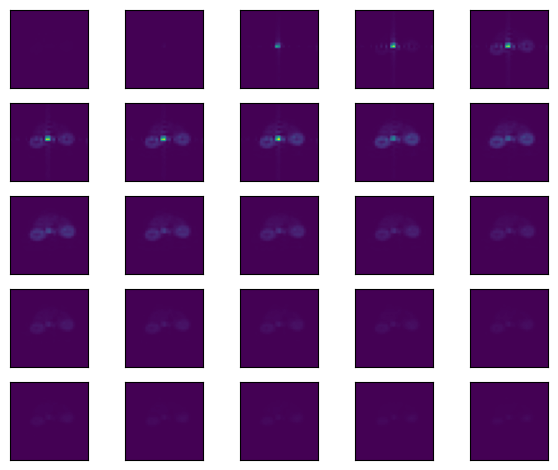

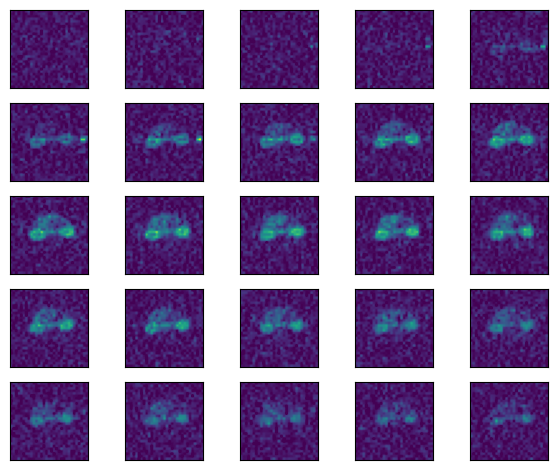

In [16]:
# quick visualization
fig = multiframeimshow(pyr, [0, np.max(pyr)], [5, 5]) # pyruvate
fig = multiframeimshow(lac, [0, np.max(lac)], [5, 5]) # pyruvate

### Fitting kPL for one voxel

In [17]:
# prepare signal from one voxel
xloc = 12
yloc = 16
S = np.expand_dims(np.stack((pyr[xloc, yloc, :], lac[xloc, yloc, :])), axis=0)
print(S.shape)

(1, 2, 25)


In [18]:
# define parameters
plot_flag = 1
flips = np.radians(np.squeeze(np.stack((flips_pyr.T,flips_lac.T),axis=1)))
params_fixed = {  # fixed parameters
    'R1P': 1 / 30,
    'R1L': 1 / 25,
}
params_est = {  # fit parameters
    'kPL': 0.002,
}

In [19]:
from compute_mean_time import *
from compute_AUCratio import *
from compute_TTP import *

  0%|          | 0/1 [00:00<?, ?it/s]

 kPL=0.0056 S0_P=64.3574 S0_L=1134.5019


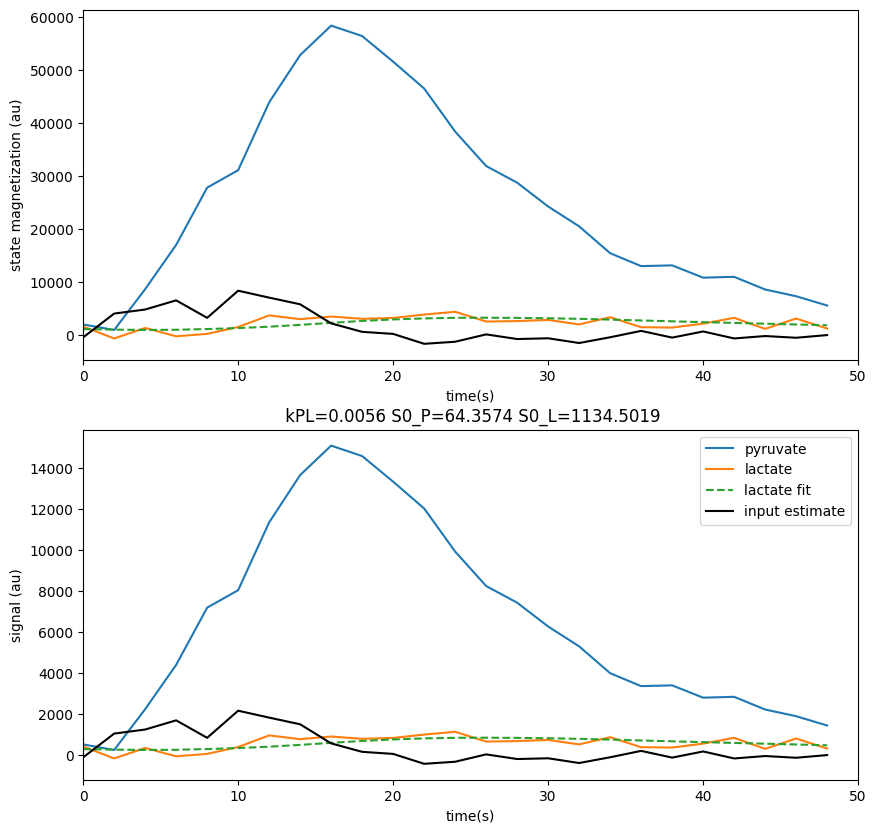

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

Rsq:
[[0.41913693]]
CHIsq:
[[1736.92973428]]
NRMSE:
[[0.43225774]]


In [16]:
# run fitting code and print some results
[Sfit, ufit, params_fit, obj_val, Rsq, CHIsq, NRMSE] = py_fit_pyr_kinetics(S, TR, flips, params_fixed, params_est, plot_flag)

print('Rsq:')
print(Rsq)
print('CHIsq:')
print(CHIsq)
print('NRMSE:')
print(NRMSE)

### Fitting kPL across all voxels & display kPL map

In [18]:
# prepare signal from full image
S = np.transpose(np.stack((pyr, lac), axis=3), (0, 1, 3, 2))
print(S.shape)

(32, 32, 2, 25)


In [19]:
# define parameters
plot_flag = 0
flip_angles = np.radians(np.squeeze(np.stack((flips_pyr.T,flips_lac.T),axis=1)))
params_fixed = {  # fixed parameters
    'R1P': 1 / 30,
    'R1L': 1 / 25,
}
params_est = {  # fit parameters
    'kPL': 0.002,
}

In [20]:
# run fitting function and print some results (note: this will take ~3 mins)
[Sfit, ufit, params_fit, obj_val, Rsq, CHIsq, NRMSE] = py_fit_pyr_kinetics(S, TR, flip_angles, params_fixed, params_est, plot_flag)

print(params_fit.shape)

100%|██████████| 1024/1024 [02:43<00:00,  6.25it/s]

(1024, 3)


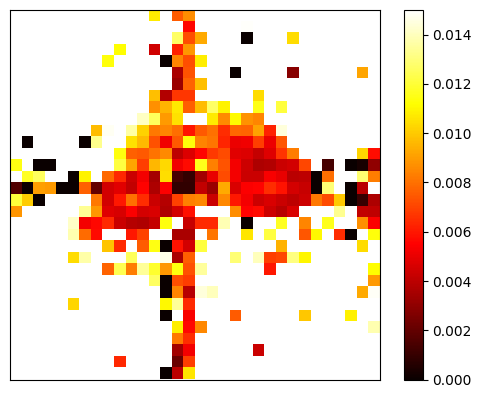

In [22]:
# visualize kPL map
params_fit_map = np.reshape(params_fit, (32, 32, 3))
kpl_map = params_fit_map[:,:,0]

ax = plt.imshow(kpl_map, cmap='hot', clim=(0, 0.015))
plt.colorbar()
y_ax = ax.axes.get_yaxis()
y_ax.set_visible(False)
x_ax = ax.axes.get_xaxis()
x_ax.set_visible(False)
